ELECTRIC VEHICLE DATA ANALYSIS 

DATA CLEANING 

1. How many missing values exist in the dataset, and in which columns?

In [1]:
import pandas as pd
df = pd.read_csv(r"C:\Users\srine\Downloads\Electric_Vehicle_Population_Data.csv")

In [2]:
# Count NaN values per column
dfm = df.isnull().sum()
print(dfm)

VIN (1-10)                                             0
County                                                10
City                                                  10
State                                                  0
Postal Code                                           10
Model Year                                             0
Make                                                   0
Model                                                  0
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         3
Base MSRP                                              3
Legislative District                                 628
DOL Vehicle ID                                         0
Vehicle Location                                      18
Electric Utility                                      10
2020 Census Tract                                     10
dtype: int64


In [3]:
#check zeros in Base MSRP & Electric Range (treated as missing)
print("Zero MSRP count:", (df['Base MSRP'] == 0).sum())
print("Zero Electric Range count:", (df['Electric Range'] == 0).sum())

Zero MSRP count: 258510
Zero Electric Range count: 160888


2. How should missing or zero values in the Base MSRP and Electric Range columns be handled?

In [4]:
df['Base MSRP'] = df['Base MSRP'].replace(0, pd.NA)
df['Electric Range'] = df['Electric Range'].replace(0, pd.NA)

In [5]:
# Fill MSRP: median per Make+Model+Year, else overall median
df['Base MSRP'] = df.groupby(['Make', 'Model', 'Model Year'])['Base MSRP']\
                   .transform(lambda x: x.fillna(x.median()))
df['Base MSRP'] = df['Base MSRP'].fillna(df['Base MSRP'].median())

C:\Users\srine\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\srine\AppData\Local\Temp\ipykernel_26632\4259321244.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .transform(lambda x: x.fillna(x.median()))
C:\Users\srine\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\srine\AppData\Local\Temp\ipykernel_26632\4259321244.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead.

In [6]:
# Fill Electric Range: median per Make+Model+Year, else by EV Type
df['Electric Range'] = df.groupby(['Make', 'Model', 'Model Year'])['Electric Range']\
                        .transform(lambda x: x.fillna(x.median()))
df['Electric Range'] = df.groupby(['Electric Vehicle Type'])['Electric Range']\
                        .transform(lambda x: x.fillna(x.median()))

C:\Users\srine\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\srine\AppData\Local\Temp\ipykernel_26632\2930268041.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .transform(lambda x: x.fillna(x.median()))
C:\Users\srine\AppData\Local\Temp\ipykernel_26632\2930268041.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .transform(lambda x: x.fillna(x.median()))
C:\Users\srine\AppData\Local\Temp\ipykernel_26632\29302

Replaces zeros with NaN, then imputes missing values using medians.

Summary:

Base MSRP: Missing values are replaced with the median price of the same Make + Model + Year. If still missing, the overall median MSRP is used.

Electric Range: Missing values are replaced with the median of the same Make + Model + Year, and if still missing, with the median of the EV type (BEV or PHEV).
This ensures realistic and consistent values without distorting analysis.

3. Are there duplicate records in the dataset? If so, how should they be managed?

In [7]:
# Check for duplicates
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 0


In [8]:
# Drop exact duplicate rows
df = df.drop_duplicates()

Finds and removes exact duplicates, and ensures only unique VINs remain.

Summary:
Duplicate records are removed from the dataset. If multiple rows share the same VIN, only one entry is retained, ensuring each vehicle is counted once.

4. How can VINs be anonymized while maintaining uniqueness?

In [9]:
# Drop duplicates by VIN (since VIN should be unique)
df = df.drop_duplicates(subset=['VIN (1-10)'])

In [10]:
import hashlib

# Create anonymized VINs using hashing
def hash_vin(vin):
    return hashlib.sha256(vin.encode()).hexdigest()[:12]  # 12 chars for readability

df['VIN_Anon'] = df['VIN (1-10)'].astype(str).apply(hash_vin)

# Drop the original VIN column for privacy
df = df.drop(columns=['VIN (1-10)'])


Applies SHA256 hashing to create anonymized VINs, then drops the original VIN column.

Summary:
VINs are anonymized using hashing so that privacy is protected while uniqueness is maintained. This way, each vehicle remains uniquely identifiable in the dataset, but without exposing sensitive details.

5. How can Vehicle Location (GPS coordinates) be cleaned or converted for better readability?

In [11]:
import re

# Remove invalid "0,0" if present
df['Vehicle Location'] = df['Vehicle Location'].replace({"0,0": pd.NA})

# Extract longitude and latitude from WKT format: "POINT (lon lat)"
def clean_location(loc):
    if pd.isna(loc):
        return pd.NA
    match = re.match(r"POINT \((-?\d+\.\d+)\s+(-?\d+\.\d+)\)", loc)
    if match:
        lon, lat = match.groups()
        # Round to 4 decimals
        return f"{round(float(lat), 4)}, {round(float(lon), 4)}"
    return pd.NA  # If not matching the expected format

df['Vehicle Location Cleaned'] = df['Vehicle Location'].apply(clean_location)

# Drop the old column if you only want cleaned version
df = df.drop(columns=['Vehicle Location'])


Replaces "0,0" with NaN and rounds GPS coordinates for readability.

Summary:
Vehicle Location data is cleaned by removing invalid entries and converting coordinates into a more readable format with 4 decimal precision. Optionally, they can also be mapped to cities/counties for better human understanding.

DATA EXPLORATION

1. What are the top 5 most common EV makes and models in the dataset?

In [12]:
dfc = df['Make'].value_counts().head(5)
print(dfc)

Make
TESLA        1681
VOLVO        1477
FORD         1283
AUDI         1188
CHEVROLET    1107
Name: count, dtype: int64


In [13]:
dfm = df['Model'].value_counts().head(5)
print(dfm)

Model
MODEL S           557
MODEL X           542
XC90              532
MUSTANG MACH-E    496
VOLT              440
Name: count, dtype: int64


Summary : This shows which makes and models dominates in Washington's EV Market. 

2. Use a heatmap or choropleth map to visualize EV distribution by county.

In [14]:
county_counts = df['County'].value_counts()
print(county_counts)

County
King            10061
Clark            1493
Snohomish        1038
Kitsap            842
Thurston          600
Pierce            423
Yakima            158
Cowlitz           155
Spokane           154
Island            119
Whatcom           117
Jefferson         116
Benton             75
Skagit             61
Clallam            42
Chelan             35
San Juan           35
Mason              31
Kittitas           31
Walla Walla        19
Grant              19
Grays Harbor       19
Whitman            18
Lewis              15
Stevens            13
Franklin           12
Klickitat          10
Douglas             8
Pacific             7
Okanogan            4
Ferry               3
Adams               2
El Paso             2
Asotin              2
Skamania            2
Sussex              1
Pend Oreille        1
Columbia            1
Maricopa            1
Leavenworth         1
San Mateo           1
San Diego           1
Hennepin            1
Macomb              1
Name: count, dtype: int64

In [15]:
#Top county
top_county = df['County'].value_counts().head(5)
print(top_county)

County
King         10061
Clark         1493
Snohomish     1038
Kitsap         842
Thurston       600
Name: count, dtype: int64


In [16]:
#Print the single top county in distribution
county = df['County'].value_counts().idxmax()
print(county)

King


The output shows the distribution of EV's across washington counties. The highest number counties like King County has the most  EV registration.

3. How has EV adoption changed over different model years?

In [17]:
model_year = df['Model Year'].value_counts().sort_index()
print(model_year)

Model Year
2000       6
2002       1
2003       1
2008      11
2010      12
2011      39
2012     155
2013     265
2014     322
2015     363
2016     470
2017     565
2018     689
2019     752
2020     818
2021    1215
2022    1860
2023    2323
2024    2893
2025    2724
2026     269
Name: count, dtype: int64


Summary: This shows the trend of EV adoption over time. A sharp increase in recent years indicates growing adoption of EVs.

4. What is the average electric range of EVs in the dataset?

In [18]:
avg_range = df["Electric Range"].mean()
print(round(avg_range,2) ,"miles")

141.3 miles


Summary: Provides the overall average electric range, useful for understanding technological progress and practicality of EVs.

5. What percentage of EVs are eligible for Clean Alternative Fuel Vehicle (CAFV) incentives?

In [19]:
eligible_pct = (df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'] == "Clean Alternative Fuel Vehicle Eligible").mean() * 100
print(round(eligible_pct, 2), "%")

31.37 %


Summary: Shows the share of EVs in the dataset that qualify for state/federal incentives, which supports policy evaluation.

6.How does the electric range vary across different makes and models?

In [20]:
avg_range_make = df.groupby('Make')['Electric Range'].mean().sort_values(ascending =False)
print(avg_range_make.head(10))

Make
JAGUAR                    228.324675
TESLA                     226.061273
POLESTAR                  216.356164
GENESIS                   215.000000
ACURA                     215.000000
BRIGHTDROP                215.000000
LUCID                     215.000000
GMC                       215.000000
RIVIAN                    215.000000
MULLEN AUTOMOTIVE INC.    215.000000
Name: Electric Range, dtype: float64


In [21]:
avg_range_model = df.groupby('Model')['Electric Range'].mean().sort_values(ascending =False)
print(avg_range_model.head(10))

Model
MACAN       241.000000
ROADSTER    235.178571
BOLT EV     233.786408
MODEL X     231.204797
I-PACE      228.324675
MODEL 3     226.474510
KONA        226.133929
MODEL S     223.344704
MODEL Y     221.430769
PS2         216.980000
Name: Electric Range, dtype: float64


Summary: Highlights which brands and models offer the longest ranges. 

7. What is the average Base MSRP for each EV model?

In [22]:
avg_msrp_model = df.groupby('Model')['Base MSRP'].mean().sort_values(ascending=False)
print(avg_msrp_model.head(10))

Model
918         845000.000000
ROADSTER    105748.214286
KARMA       102000.000000
740E         90142.500000
PANAMERA     89542.857143
CT6          75095.000000
MODEL S      62126.211849
CAYENNE      61702.000000
XC90         60127.819549
A8 E         59900.000000
Name: Base MSRP, dtype: float64


Summary: Shows pricing trends — luxury 918 EVs have higher MSRP, while A8 E have lower MSRP.

8. Are there any regional trends in EV adoption (e.g., urban vs. rural areas)?

In [23]:
urban_counties = ["King", "Pierce", "Snohomish", "Spokane", "Clark"]
df['Region'] = df['County'].apply(lambda x: "Urban" if x in urban_counties else "Rural")
print(df['Region'].value_counts())

Region
Urban    13169
Rural     2584
Name: count, dtype: int64


Summary: This categorizes counties into urban vs rural and compares adoption. Typically, urban counties show much higher EV adoption due to infrastructure and income levels.

Data Visualization

1. Create a bar chart showing the top 5 EV makes and models by count.

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

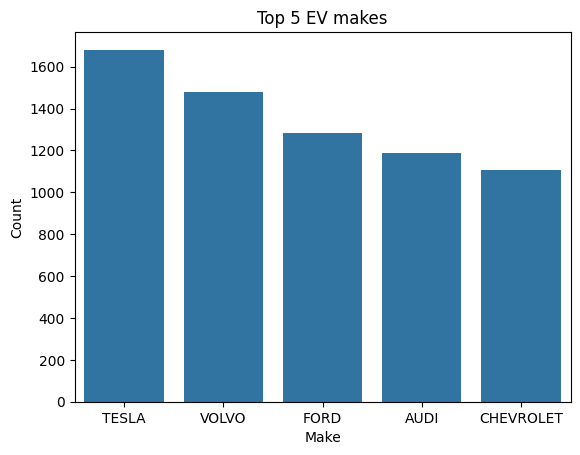

In [25]:
top_makes = df['Make'].value_counts().head(5)
sns.barplot(x=top_makes.index, y=top_makes.values)
plt.title("Top 5 EV makes")
plt.ylabel("Count")
plt.show()

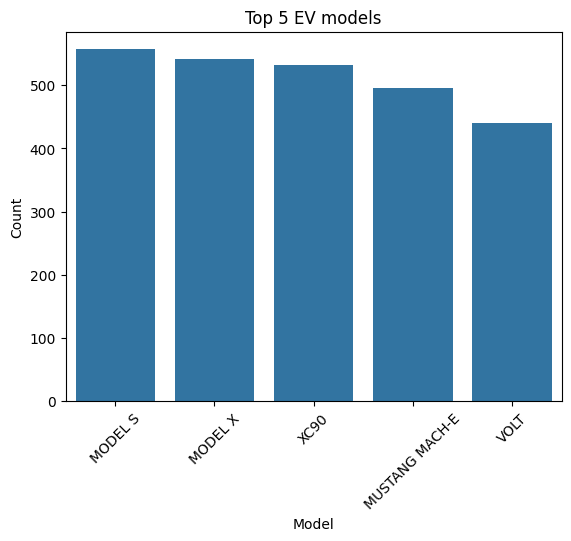

In [26]:
top_models = df['Model'].value_counts().head(5)
sns.barplot(x=top_models.index, y=top_models.values)
plt.title("Top 5 EV models")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

The most popular EV brands and models by registration count.
Reveals consumer preferences and dominant automakers in the EV market.

2. Use a heatmap or choropleth map to visualize EV distribution by county.

In [27]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [28]:
import geopandas as gpd

In [29]:
map = gpd.read_file(r"C:\Users\srine\Downloads\tl_2025_us_county\tl_2025_us_county.shp")

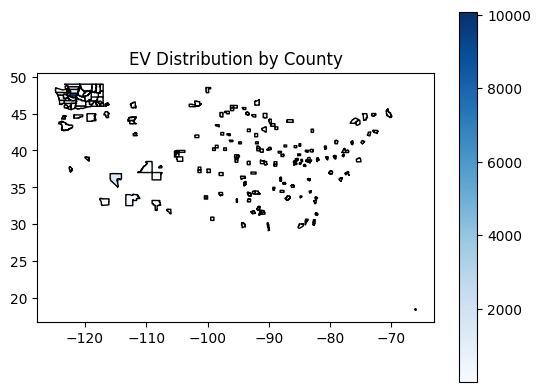

In [30]:
# Count EVs per county
county_counts = df['County'].value_counts().reset_index()
county_counts.columns = ['County', 'Count']

# Merge with shapefile
wa_map = map.merge(county_counts, left_on="NAME", right_on="County")

# Plot choropleth
wa_map.plot(column='Count', cmap='Blues', legend=True, edgecolor="black")
plt.title("EV Distribution by County")
plt.show()

The geographic spread of EV registrations across Washington State.
Helps identify urban vs. rural adoption patterns, showing hotspots like Seattle or King County where EV use is concentrated.

3. Create a line graph showing the trend of EV adoption by model year.

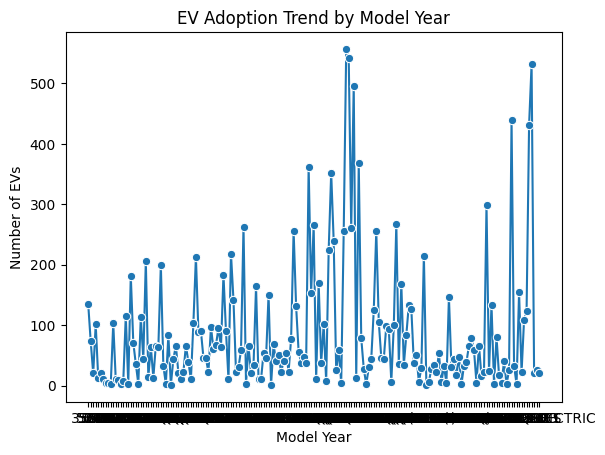

In [31]:
year_counts = df['Model'].value_counts().sort_index()
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o')
plt.title("EV Adoption Trend by Model Year")
plt.xlabel("Model Year")
plt.ylabel("Number of EVs")
plt.show()

4.Generate a scatter plot comparing electric range vs. base MSRP to see pricing trends.

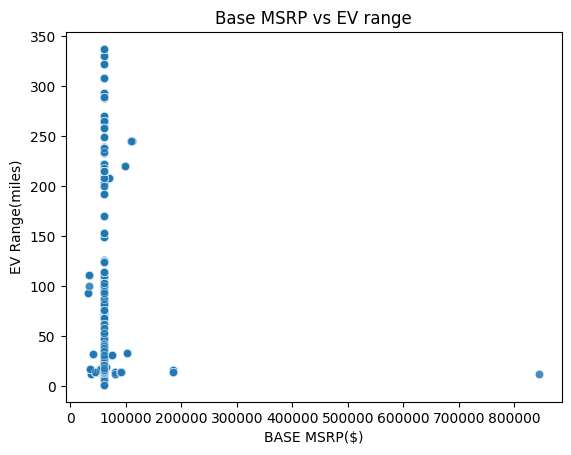

In [32]:
sns.scatterplot(data=df, x="Base MSRP" , y="Electric Range", alpha=0.6)
plt.title("Base MSRP vs EV range")
plt.xlabel("BASE MSRP($)")
plt.ylabel("EV Range(miles)")
plt.show()           

5. Plot a pie chart showing the proportion of CAFV-eligible vs. non-eligible EVs.

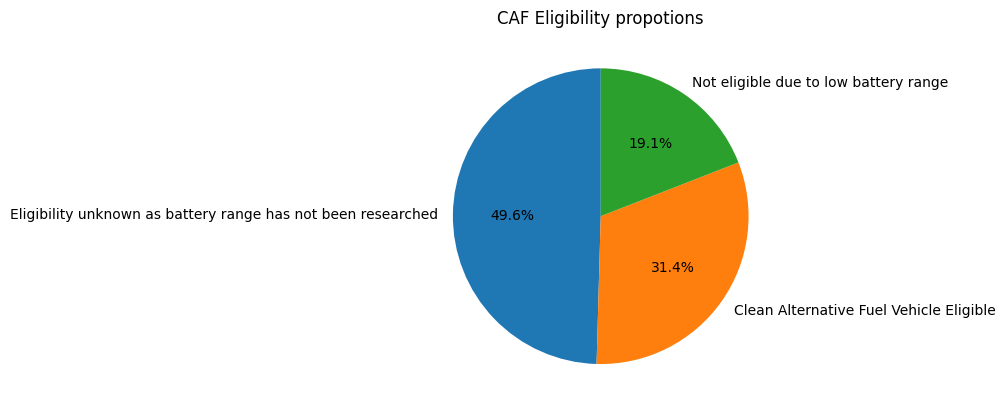

In [33]:
caf_counts = df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts()
plt.pie(caf_counts, labels=caf_counts.index , autopct = "%1.1f%%", startangle =90)
plt.title("CAF Eligibility propotions")
plt.show()

6. Use a geospatial map to display EV registrations based on vehicle location.

In [34]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [35]:
import folium

# Make a fresh map
m = folium.Map(location=[47.5, -120.5], zoom_start=7)

# Add markers
for loc in df['Vehicle Location'].dropna():
    lat, lon = map(float, loc.split(','))
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color='purple',
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

m.save("ev_map.html")

KeyError: 'Vehicle Location'

LINEAR REGRESSION MODEL QUESTIONS

1. How can we use Linear Regression to predict the Electric Range of a vehicle?

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [39]:
x = df[['Model Year' , 'Base MSRP']]
y = df['Electric Range']

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y , test_size = 0.2, random_state = 42)

In [44]:
model = LinearRegression()
model.fit(X_train, Y_train)

print("Model Trained to predict Electric Range")

Model Trained to predict Electric Range


2. What independent variables (features) can be used to predict Electric Range? (e.g., Model Year, Base MSRP, Make)

In [45]:
print(df[['Model Year', 'Base MSRP', 'Make', 'Model']].head())

   Model Year  Base MSRP    Make    Model
0        2013    59900.0  TOYOTA    PRIUS
1        2025    59900.0    FORD   ESCAPE
2        2024    59900.0   MAZDA    CX-90
3        2023    59900.0   TESLA  MODEL Y
4        2019    59900.0   TESLA  MODEL 3


It just shows you the columns (Model Year, Base MSRP, Make, Model) that could be used as independent variables.

3. How do we handle categorical variables like Make and Model in regression analysis?

In [48]:
import pandas as pd

X_encoded = pd.get_dummies(df[['Model', 'Make']], drop_first = True).astype(int)
print(" Encoded categorical Variables:\n" , X_encoded.head()) 

 Encoded categorical Variables:
    Model_500  Model_500E  Model_530E  Model_550E  Model_740E  Model_745E  \
0          0           0           0           0           0           0   
1          0           0           0           0           0           0   
2          0           0           0           0           0           0   
3          0           0           0           0           0           0   
4          0           0           0           0           0           0   

   Model_745LE  Model_750E  Model_918  Model_A3  ...  Make_ROLLS-ROYCE  \
0            0           0          0         0  ...                 0   
1            0           0          0         0  ...                 0   
2            0           0          0         0  ...                 0   
3            0           0          0         0  ...                 0   
4            0           0          0         0  ...                 0   

   Make_SMART  Make_SUBARU  Make_TESLA  Make_TH!NK  Make_TOYOTA  

4. What is the R² score of the model, and what does it indicate about prediction accuracy?

In [49]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)
r2 = r2_score(y_pred, Y_test)
print("R2 Score:", r2)

R2 Score: -8.464900863826287


5. How does the Base MSRP influence the Electric Range according to the regression model?

In [51]:
print("Coefficient for Base MSRP:", model.coef_[list(x.columns).index('Base MSRP')])

Coefficient for Base MSRP: 5.9085718147020307e-05


6. What steps are needed to improve the accuracy of the Linear Regression model?

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [55]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor',LinearRegression())
])

In [56]:
pipeline.fit(X_train, Y_train)
print("Improved Model Train for scaling")

Improved Model Train for scaling


7. Can we use this model to predict the range of new EV models based on their specifications?

In [58]:
new_data = pd.DataFrame({
    'Model Year': [2024],
    'Base MSRP': [55000]
})

In [59]:
predicted_range = model.predict(new_data)
print("Predicted Electric Range for new EV:", predicted_range[0])

Predicted Electric Range for new EV: 161.8767814965322
